# Loading timetable

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from planner import JourneyPlanner
from collections import defaultdict
import pickle

In [3]:
with open('../data/footpath.pickle', 'rb') as f:
    footpaths = pickle.load(f)

In [4]:
with open('../data/trips.pickle', 'rb') as f:
    trips = pickle.load(f)

In [5]:
with open('../data/stops.pickle', 'rb') as f:
    stops = pickle.load(f)

In [6]:
with open('../data/connections_data.pickle', 'rb') as f:
    connections = pickle.load(f)

In [7]:
with open('../data/confidence.pickle', 'rb') as f:
    confidences = pickle.load(f)

In [8]:
stops['8500926']

{'stop_id': '8500926',
 'stop_name': 'Oetwil a.d.L., Schweizäcker',
 'stop_lat': '47.4236270123012',
 'stop_lon': '8.4031825286317',
 'parent_station': ''}

In [9]:
paper_conn = [[
    ("y", "t", 100000, 110000, "1"),
    ("z", "t", 90000, 120000, "2"),
    ("x", "t", 80000, 130000, "3"),
    ("x", "y", 80000, 90000, "4"),
    ("s", "z", 70000, 80000, "5"),
    ("s", "x", 60000, 70000, "6"),
    ("s", "t", 50000, 140000, "7")
]]
timetable = (None, paper_conn, None, defaultdict(lambda: list()))

In [10]:
timetable = stops, connections, trips, footpaths, confidences

# Planning a route and defining function to plot

In [13]:
planner = JourneyPlanner(timetable)

journeys = planner.plan_route(4, "8503000:0:9", "8590632", 1653453975, 1653471975, minimum_confidence = 0, max_changes = 3, verbose=True)

#the following makes the connection index go out of range
# journeys = planner.plan_route(2, "8502555", "8502495", 1653491740, 1653501740, max_changes = 10)

#the following makes the kernel die
#s = planner.plan_route(3, "8503000", "8590318", 1653491740, 1653501740, 10)
print(len(journeys))

Starting execution of CSA...
Starting extraction of paths... found 8 paths.
Starting processing of paths... processed 8 journeys.
Starting sorting of paths...
End of computation.
8


In [16]:
j = journeys[0]

In [17]:
from planner import JourneyPlanner
from collections import defaultdict
import pickle
import ipywidgets as widgets
from IPython.display import display, clear_output
import datetime
import plotly.graph_objects as go
import pandas as pd
import plotly.express as px
import plotly
import matplotlib.pyplot as plt
import pickle
from journey import *

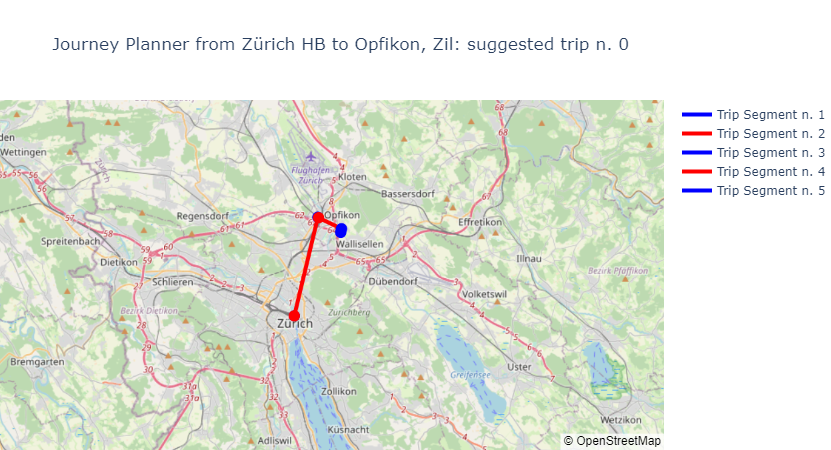

In [73]:
def visualize_map_scattermapbox(journey, plot_number = 0):
    
    # the funtcion takes as input path, which is a list of lists containing the ids of the stations
    
    # l is the layout of the plot, we use to set the title, the margins and the style of the map
    departure_station = journey.links[0].dep_stop['stop_name']
    arrival_station = journey.links[-1].arr_stop['stop_name']
    l = go.Layout(
        title= f'Journey Planner from {departure_station} to {arrival_station}: suggested trip n. {plot_number}', 
        margin ={'l':0,'t':100,'b':0,'r':0},
        mapbox = {
            'center': {'lon': 10, 'lat': 10},
            'style': "open-street-map",
            'center': {'lon':8.57 , 'lat': 47.40},
            'zoom': 9.8,},
        title_x = 0.41
    )
    
    # we initialize the map with the layout we created above
    
    fig = go.Figure(go.Scattermapbox(
            mode = "markers+lines",
            marker = {'size': 10},
            ), l)
    
    # here we iterate through the path in order to plot each part of the trip
    i = 0
    for x in journey.links:
        color = 'red'
        if isinstance(x, Change):  # skipping changes
#             print("skipping a Change. Changes should not be plotted")
            continue
        if isinstance(x, Footpath):
            color = 'blue'
            
#         arr_key = x.arr_stop
#         dep_key = x.dep_stop
#         arr_df = pd.DataFrame(stops[arr_key], index = ["arr"])
#         dep_df = pd.DataFrame(stops[dep_key], index = ["dep"])
        
        arr_df = pd.DataFrame(x.arr_stop, index = ["arr"])
        dep_df = pd.DataFrame(x.dep_stop, index = ["dep"])
        
        a = pd.concat([arr_df, dep_df])
#         fig.add_trace(go.Scattermapbox(
#             mode = "markers+lines",
#             lon = a.stop_lon,
#             lat = a.stop_lat,
#             marker = {'size': 10, 'color' : color},
#             name = f"Trip segment n. {i+1}",
#             hovertext = x.dep_stop['stop_name']))
        
        
        
        fig.add_trace(go.Scattermapbox(mode = "lines",
                                        lon = a.stop_lon,
                                        lat = a.stop_lat,
#                                         name=ttype,
                                        marker = {'color': color},
                                        line={'width':4},
                                        name = f"Trip Segment n. {i+1}"))

        fig.add_trace(go.Scattermapbox(mode = "markers",
                                        lon = [x.dep_stop['stop_lon']],
                                        lat = [x.dep_stop['stop_lat']],
                                        showlegend=False,
                                        marker = {'size': 12,'color': color},
                                        hovertext = x.dep_stop['stop_name']))
        
        
        
        
        
        i += 1
        
    fig.add_trace(go.Scattermapbox(mode = "markers",
                                        lon = [x.arr_stop['stop_lon']],
                                        lat = [x.arr_stop['stop_lat']],
                                        showlegend=False,
                                        marker = {'size': 12,'color': color},
                                        hovertext = x.arr_stop['stop_name']))

#     plotly.offline.plot(fig)               #uncomment this if you want the map to open also in a new tab of the browser
    fig.show()

   

visualize_map_scattermapbox(j)

# Setting up the widgets and plotting

In [66]:
import ipywidgets as widgets
from IPython.display import display, clear_output

In [67]:
stop_names = []
for key in stops.keys():
    stop_names.append(stops[key]["stop_name"])

stop_names = np.unique(sorted(stop_names))

In [71]:
# Below we define all the widgets
import datetime
confidence_level =widgets.FloatSlider(
    description = "Confidence Interval",
    value=0.90,
    min=0,
    max=1.0,
    step=0.01,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    style= {'description_width': 'initial'}
)

datetime_picker = widgets.DatePicker(
    value = datetime.datetime.now().date(),
    description='Date of the trip',
    disabled=False,
    style= {'description_width': 'initial'}
)

aux = datetime.datetime.now()
max_arrival_time_hour = widgets.Dropdown(
    value = datetime.datetime.now().time().hour + 1,
    options= [i for i in range(1,25)],
    description='Max Hour:',
    disabled=False,
    style= {'description_width': 'initial'}
)

max_arrival_time_minute = widgets.Dropdown(
    value = datetime.datetime.now().time().minute,
    options= [i for i in range(1,60)],
    description='Max Minute:',
    disabled=False,
    style= {'description_width': 'initial'}
)


min_departure_time_hour = widgets.Dropdown(
    value = datetime.datetime.now().time().hour,
    options= [i for i in range(1,25)],
    description='Min Hour:',
    disabled=False,
    style= {'description_width': 'initial'}
)


min_departure_time_minute = widgets.Dropdown(
    value = datetime.datetime.now().time().minute,
    options= [i for i in range(1,60)],
    description='Min Hour:',
    disabled=False,
    style= {'description_width': 'initial'}
)



departure_station = widgets.Dropdown(
    options= stop_names,
    description='Departure Station:',
    disabled=False,
    style= {'description_width': 'initial'}
)

arrival_station = widgets.Dropdown(
    options= stop_names,
    description='Arrival Station:',
    disabled=False,
    style= {'description_width': 'initial'}
)


max_changes = widgets.IntText(
    value=10,
    description='Max. number of changes:',
    disabled=False,
)

show_k_journeys_options = ["All"]
show_k_journeys_options.extend([i for i in range(1,11)])


show_k_journeys = widgets.Dropdown(
    value = 5,
    options= show_k_journeys_options,
    description='Max n. of journeys to display:',
    disabled=False,
    style= {'description_width': 'initial'}
)

layout = widgets.Layout(width='auto', height='40px')

button = widgets.Button(
    description='Find the best route!',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click me',
    icon='check', # (FontAwesome names without the `fa-` prefix)
    layout = layout
)





out = widgets.Output()

# The following functions defines what happens when we press the button

                             
def button_action(button):
    
    out.clear_output()   # each time we press the button we clear the previous output
    
    with out:
#         for x in [datetime_picker, min_departure_time, max_arrival_time , departure_station, arrival_station, confidence_level, max_changes]:
#             if x.value is None:
#                 print("WARNING: You have to fill in all the fields!")
#                 return 
        # we extract the inputs we got from the widgets and we store them in a list
        dep_station_name = departure_station.value
        arr_station_name = arrival_station.value
        dep_station_ids = [k for k,v in stops.items() if v['stop_name'] == dep_station_name]
        arr_station_ids = [k for k,v in stops.items() if v['stop_name'] == arr_station_name]
#         try:
#             min_dep_unix_timestamp = datetime.datetime.timestamp(min_departure_time.value)*1000
#         except:
#             min_dep_unix_timestamp = None
            
#         try:
#             max_arr_unix_timestamp = datetime.datetime.timestamp(max_arrival_time.value)*1000
#         except:
#             max_arr_unix_timestamp = None
            
        weekday = datetime_picker.value.weekday()
        if not(weekday in [0,1,2,3,4]):
            raise Exception("You cannot choose Saturday or Sunday")
#         dep_weekday = max_arrival_time.value.weekday() - 1
#         arr_weekday = max_arrival_time.value.weekday() - 1
        
        a = datetime.time(max_arrival_time_hour.value, max_arrival_time_minute.value)
        b = datetime.time(min_departure_time_hour.value, min_departure_time_minute.value)
        date_value_from_connections = datetime.datetime.fromtimestamp(connections[0][2])
#         inputs = [datetime_picker.value, min_departure_time.value, max_arrival_time.value, dep_station_ids, arr_station_ids, confidence_level.value, max_changes.value]
        timestamp1 = int(datetime.datetime.combine(date_value_from_connections, b).timestamp())
        timestamp2 = int(datetime.datetime.combine(date_value_from_connections, a).timestamp())
        inputs = [weekday, dep_station_ids[0], arr_station_ids[0], timestamp1, timestamp2, max_changes.value, confidence_level.value]
#         print("INPUTS:", inputs)
#         print("Inputs che passiamo alla funzione:", [weekday, dep_station_ids[0], arr_station_ids[0], timestamp1, timestamp2, confidence_level.value,max_changes.value])
        planner = JourneyPlanner(timetable)
        journeys = planner.plan_route(weekday, dep_station_ids[0], arr_station_ids[0], timestamp1, timestamp2, confidence_level.value, max_changes.value)
        
        # now we call the function to get the optimal path (CSA)
#         path = get_path(inputs)
        #we visualize the optimal path using the function we defined in the previous section
#         visualize_map_scattermapbox(path)
#         visualize_map_mapline(path)
        print("Total Number of journeys found", len(journeys))
        if show_k_journeys.value == "All":
            max_journeys = len(journeys)
        else:
            max_journeys = show_k_journeys.value
            
        for i in range(len(journeys[:max_journeys])):
#             print(f"Journey {i}")
            visualize_map_scattermapbox(journeys[i], i+1)
        
button.on_click(button_action)

In [72]:
import datetime
display(datetime_picker, min_departure_time_hour,min_departure_time_minute, max_arrival_time_hour, max_arrival_time_minute , departure_station, arrival_station, confidence_level, max_changes, show_k_journeys, button, out)

DatePicker(value=datetime.date(2022, 5, 28), description='Date of the trip', style=DescriptionStyle(descriptio…

Dropdown(description='Min Hour:', index=7, options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,…

Dropdown(description='Min Hour:', index=44, options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17…

Dropdown(description='Max Hour:', index=8, options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,…

Dropdown(description='Max Minute:', index=44, options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, …

Dropdown(description='Departure Station:', options=('Aathal', 'Adlikon b. R., Dorf', 'Adlikon b. R., Leematten…

Dropdown(description='Arrival Station:', options=('Aathal', 'Adlikon b. R., Dorf', 'Adlikon b. R., Leematten',…

FloatSlider(value=0.9, continuous_update=False, description='Confidence Interval', max=1.0, step=0.01, style=S…

IntText(value=10, description='Max. number of changes:')

Dropdown(description='Max n. of journeys to display:', index=5, options=('All', 1, 2, 3, 4, 5, 6, 7, 8, 9, 10)…

Button(description='Find the best route!', icon='check', layout=Layout(height='40px', width='auto'), style=But…

Output()